# Implementation of AutoArima by Nixtla (faster compared to pmdarima)

In [44]:
from pylab import rcParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsforecast.arima import arima_string

import warnings
warnings.filterwarnings("ignore")

# Set style features
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12}
plt.rcParams.update(dark_style)

rcParams['figure.figsize'] = (18, 7)

In [45]:
# # Import the data
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    # Convert 'date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [46]:
# Load in the train and test data
train_df = load_and_prepare_data(
    '../../../data/Final_data/train_df_no_lags.csv')
test_df = load_and_prepare_data('../../../data/Final_data/test_df_no_lags.csv')

# Concatenate the train and test data
df = pd.concat([train_df, test_df])
df['Date'] = pd.to_datetime(df['Date'])

In [47]:
# Prepare the data
def prepare_data(df):
    df = df.rename(columns={'Date': 'ds', 'Day_ahead_price (€/MWh)': 'y'})
    df['unique_id'] = '1'  # Single time series ID
    df['ds'] = pd.to_datetime(df['ds'])
    return df


# Apply preprocessing to train and test DataFrames
train_df = prepare_data(train_df)
test_df = prepare_data(test_df)

In [48]:
# Daily data
season_length = 7
# Define the model
models = [AutoARIMA(season_length=season_length, ic='bic')]

# Initialize AutoARIMA model with exogenous variables (covariates)
covariates = [col for col in train_df.columns if col not in [
    'ds', 'y', 'unique_id']]

# Initialize StatsForecast without passing X_df
sf = StatsForecast(df=train_df,
                   models=models,
                   freq='D',
                   n_jobs=-1)

# Fit the model
sf.fit(train_df)

# Show model configuration
print(arima_string(sf.fitted_[0, 0].model_))

Regression with ARIMA(2,1,2)(0,0,2)[7] errors


## Prediction using the forecast method

In [49]:
# Step 1: Ensure expected covariates list matches the covariates in train_df
expected_covariates = [col for col in train_df.columns if col not in ['y']]

# Step 2: Create X_df with the updated list of expected covariates
horizon = len(test_df)
X_df = test_df[expected_covariates]

# Generate forecasts, providing the required exogenous features through `X_df`
try:
    predictions = sf.forecast(horizon, X_df=X_df, fitted=True, level=[80])
    print(predictions.head())
except ValueError as e:
    print("Error during forecast:", e)

                  ds   AutoARIMA  AutoARIMA-lo-80  AutoARIMA-hi-80
unique_id                                                         
1         2022-07-01  280.179315       265.442347       294.916284
1         2022-07-02  269.903741       252.945889       286.861592
1         2022-07-03  264.003581       246.807853       281.199308
1         2022-07-04  304.362741       287.045088       321.680394
1         2022-07-05  328.298350       310.960107       345.636593


In [50]:
values = sf.forecast_fitted_values()
values

,ds,y,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
unique_id,,,,,
1,2012-01-08,26.83,26.940495,12.203526,41.677463
1,2012-01-09,47.91,49.414059,34.677090,64.151027
1,2012-01-10,45.77,40.631161,25.894193,55.368130
1,2012-01-11,47.83,46.348585,31.611616,61.085554
1,2012-01-12,43.10,32.346213,17.609244,47.083181
...,...,...,...,...,...
1,2022-06-26,201.67,224.312921,209.575953,239.049890
1,2022-06-27,316.65,245.554296,230.817327,260.291265
1,2022-06-28,331.52,295.996581,281.259612,310.733549


In [51]:
predictions = predictions.reset_index()
predictions

,unique_id,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,1,2022-07-01,280.179315,265.442347,294.916284
1,1,2022-07-02,269.903741,252.945889,286.861592
2,1,2022-07-03,264.003581,246.807853,281.199308
3,1,2022-07-04,304.362741,287.045088,321.680394
4,1,2022-07-05,328.298350,310.960107,345.636593
...,...,...,...,...,...
754,1,2024-07-24,95.403841,71.527049,119.280633
755,1,2024-07-25,98.125982,74.242057,122.009907
756,1,2024-07-26,100.312443,76.421386,124.203500
757,1,2024-07-27,102.705940,78.807754,126.604126


In [52]:
# Save the columns ds and AutoARIMA together as csv
# rename ds to Date
save_df = predictions.copy()
save_df = save_df.rename(columns={'ds': 'Date'})
# rename AutoARIMA to Day_ahead_price (€/MWh)
save_df = save_df.rename(columns={'AutoARIMA': 'Day_ahead_price (€/MWh)'})
save_df[['Date', 'Day_ahead_price (€/MWh)']].to_csv(
    "/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/predictions/ARIMA/Nixtla_approach/forcast_values_no_lags_BIC.csv", index=False)

## Plotting results

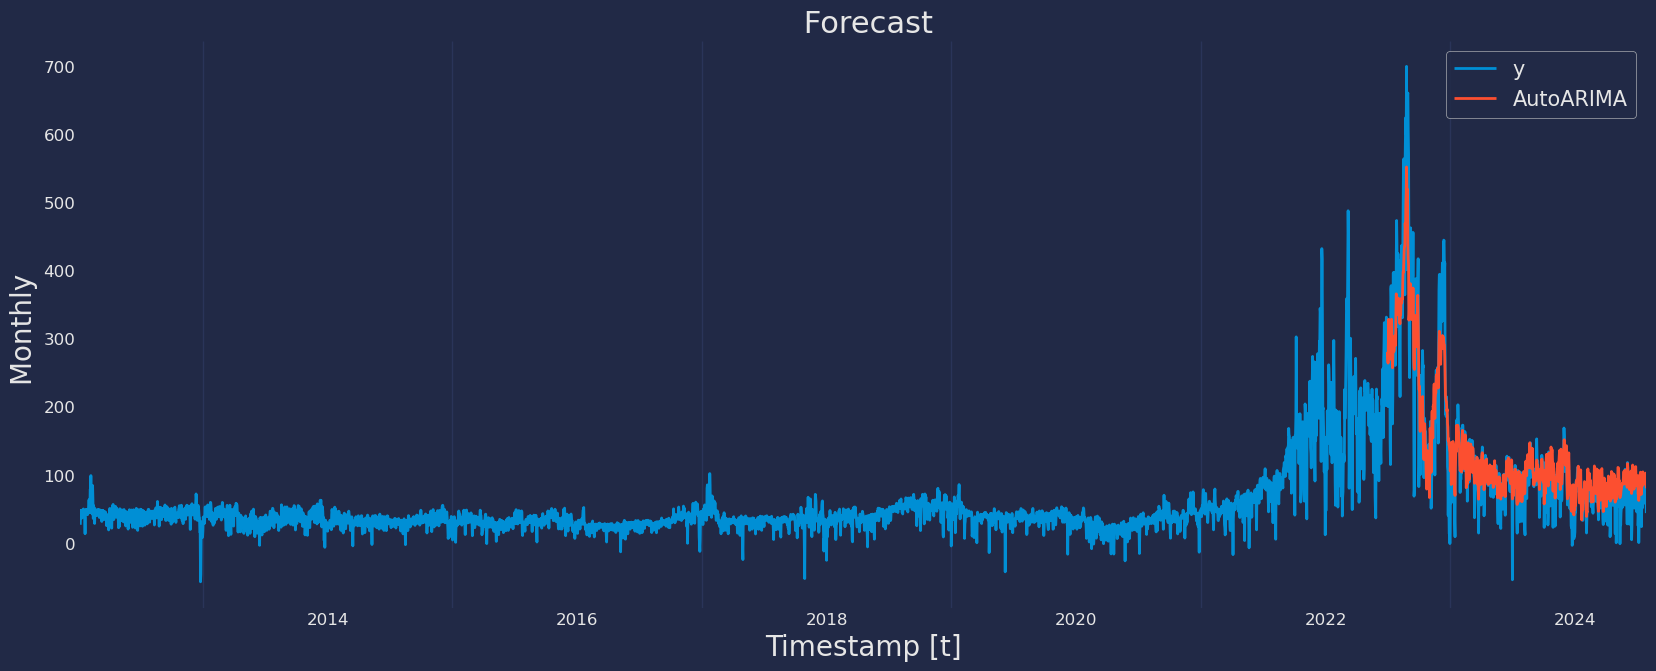

In [53]:
test_df['unique_id'] = test_df['unique_id'].astype(int)
predictions['unique_id'] = predictions['unique_id'].astype(int)
# Convert 'ds' to datetime
predictions['ds'] = pd.to_datetime(predictions['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

predictions = test_df.merge(predictions, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
plot_df = pd.concat([train_df, predictions]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [54]:
predictions

,ds,y,Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),...,BEV_vehicles,Oil_price (EUR),TTF_gas_price (€/MWh),Nuclear_energy (GWh),Day_of_week,Month,unique_id,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,2022-07-01,314.38,127.46,3.42,15.87,111.601,168.773,52.930,332.065,182.244,...,929,100.14,148.00,95.705,4,7,1,280.179315,265.442347,294.916284
1,2022-07-02,218.92,339.67,2.75,18.16,112.222,115.877,46.251,258.776,91.636,...,929,100.88,155.30,92.143,5,7,1,269.903741,252.945889,286.861592
2,2022-07-03,200.11,318.04,2.86,21.03,112.037,90.515,41.357,277.929,85.647,...,929,101.61,158.95,90.251,6,7,1,264.003581,246.807853,281.199308
3,2022-07-04,293.89,286.96,3.08,19.14,112.874,140.425,43.641,311.034,123.629,...,929,102.34,162.60,95.182,0,7,1,304.362741,287.045088,321.680394
4,2022-07-05,318.37,287.62,3.08,18.56,112.856,182.225,50.027,302.135,146.554,...,929,93.72,178.05,94.826,1,7,1,328.298350,310.960107,345.636593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,...,992,75.75,32.63,0.000,2,7,1,95.403841,71.527049,119.280633
755,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,...,992,76.36,31.70,0.000,3,7,1,98.125982,74.242057,122.009907
756,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,...,993,75.21,32.20,0.000,4,7,1,100.312443,76.421386,124.203500
757,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,...,992,74.79,32.90,0.000,5,7,1,102.705940,78.807754,126.604126


In [55]:
import plotly.graph_objects as go
import pandas as pd

# Concatenate train and forecast data but filter only test period for plotting
plot_df = pd.concat([train_df, predictions]).set_index('ds')
test_period = plot_df.loc[test_df['ds'].min():test_df['ds'].max()]

# Create figure with Plotly
fig = go.Figure()

# Add true values trace (y)
fig.add_trace(go.Scatter(
    x=test_period.index,
    y=test_period['y'],
    mode='lines',
    name='True Values',
    line=dict(width=2, color='royalblue'),
    hovertemplate='Date: %{x}<br>True Value: %{y}<extra></extra>'
))

# Add forecast values trace (AutoARIMA)
fig.add_trace(go.Scatter(
    x=test_period.index,
    y=test_period['AutoARIMA'],
    mode='lines',
    name='Predictions',
    line=dict(width=2, dash='dash', color='firebrick'),
    hovertemplate='Date: %{x}<br>Prediction: %{y}<extra></extra>'
))

# Set the layout for the figure
fig.update_layout(
    title={
        'text': "Forecast for Test Period",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 24
    },
    xaxis_title="Date",
    yaxis_title="Monthly Values",
    legend=dict(
        font=dict(size=15),
        orientation="h",
        yanchor="top",
        y=+0.95,  # Move legend below the plot
        xanchor="center",
        x=0.5
    ),
    font=dict(size=16),
    template="plotly",
    width=1100,
    height=600,
    margin=dict(l=40, r=40, t=80, b=80),
    xaxis=dict(
        tickformat="%Y-%m-%d",
        showgrid=True,
        gridcolor="lightgrey",
        tickangle=45
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="lightgrey"
    )
)

# Add vertical range for visual clarity
fig.update_xaxes(rangeslider_visible=True)

# Display the plot
fig.show()

## Error metrics

In [56]:
from datasetsforecast.losses import mae, mape, rmse, smape, mse


def evaluate_performace(y_hist, y_true, model):
    evaluation = {}
    evaluation[model] = {}
    for metric in [rmse, mse, mae, mape, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values,
                                                    y_true[model].values,
                                                    y_hist['y'].values, seasonality=7)
        else:
            evaluation[model][metric_name] = metric(
                y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [57]:
evaluate_performace(test_df, predictions, model='AutoARIMA')

,rmse,mse,mae,mape,smape
AutoARIMA,41.373324,1711.751969,26.391006,121.748521,24.032403


### Comparing with error metrics from sklearn which are also used by the darts package

In [58]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


def evaluate_performance(true_df, pred_df, model='AutoARIMA'):
    # Ensure true and predicted values are aligned
    true_values = true_df['y'].values
    pred_values = pred_df[model].values

    # Calculate metrics
    mse = mean_squared_error(true_values, pred_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, pred_values)
    mape = np.mean(np.abs((true_values - pred_values) / true_values)) * 100
    smape = 100 / len(true_values) * np.sum(2 * np.abs(pred_values -
                                                       true_values) / (np.abs(true_values) + np.abs(pred_values)))

    # Round metrics to two decimal places
    metrics = {
        'model': model,
        'rmse': round(rmse, 2),
        'mse': round(mse, 2),
        'mae': round(mae, 2),
        'mape': round(mape, 2),
        'smape': round(smape, 2)
    }

    # Create DataFrame to store metrics
    metrics_df = pd.DataFrame([metrics])

    # Save the DataFrame with metrics as "AutoArima"
    metrics_df.to_csv('AutoArima_metrics_no_lags_BIC.csv', index=False)
    print(metrics_df)


# Run the evaluation
evaluate_performance(test_df, predictions, model='AutoARIMA')

       model   rmse      mse    mae    mape  smape
0  AutoARIMA  41.37  1711.75  26.39  121.75  24.03


## Plot the residuals 

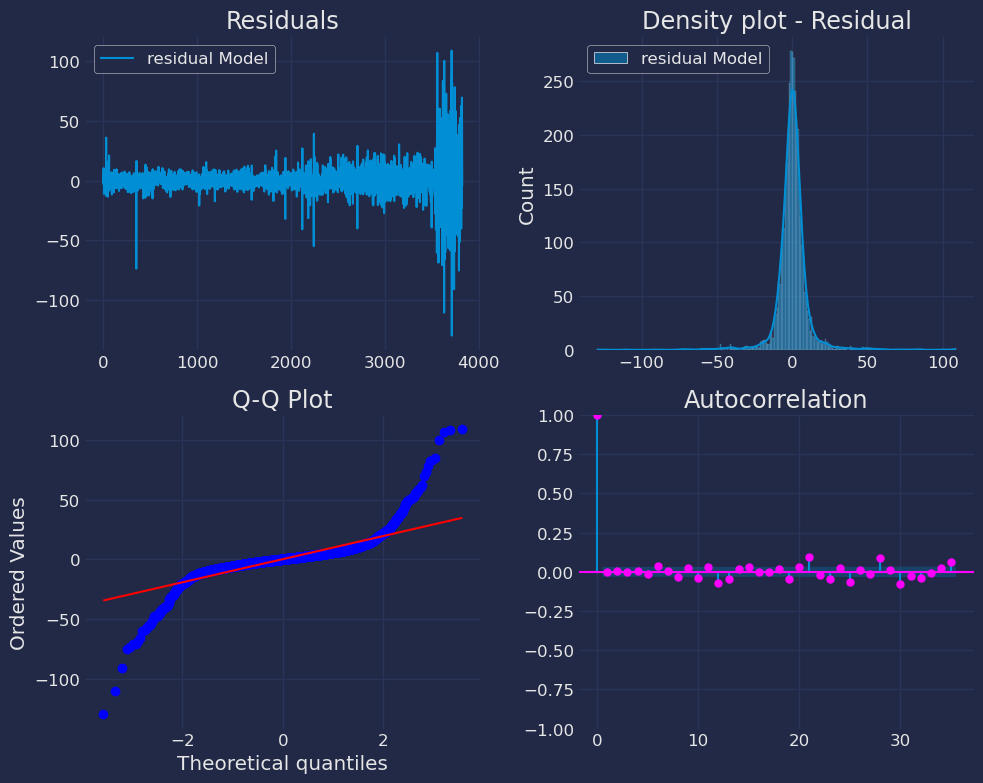

In [186]:
# Assuming `result` is a dictionary with residuals
residual = pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot [0,0]: Residuals time series
residual.plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuals")

# Plot [0,1]: Density plot of residuals
# Replaced distplot with histplot
sns.histplot(residual, kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Density plot - Residual")

# Plot [1,0]: Q-Q plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

# Plot [1,1]: Autocorrelation plot
plot_acf(residual, lags=35, ax=axs[1, 1], color="fuchsia")
axs[1, 1].set_title("Autocorrelation")

plt.tight_layout()
plt.show()

## Cross-validation

In [203]:
crossvalidation_df = sf.cross_validation(df=train_df,
                                         h=len(test_df),
                                         step_size=12,
                                         n_windows=5)

In [204]:
crossvalidation_df.head()

,ds,cutoff,y,AutoARIMA
unique_id,,,,
1,2020-04-15,2020-04-14,20.17,19.730815
1,2020-04-16,2020-04-14,25.32,23.173976
1,2020-04-17,2020-04-14,27.77,25.813947
1,2020-04-18,2020-04-14,20.23,16.620101
1,2020-04-19,2020-04-14,7.41,4.453342
